In [1]:
import numpy as np
import h5py
import os
import pandas as pd

In [2]:
%pylab inline
import matplotlib.pyplot as plt
import seaborn
seaborn.set()

Populating the interactive namespace from numpy and matplotlib


In [58]:
resultsdir = '../results/cartpole_ddpg2'

In [60]:
savedirs = {
    'normal': 'normal_buffer',
    'prioritized': 'prioritized_buffer'
}
for k in savedirs:
    savedirs[k] = os.path.join(resultsdir,savedirs[k])

In [61]:
def loadHDF5(filepath):
    output = {}
    with h5py.File(filepath,'r') as f:
        for k in f:
            output[k] = np.array(f[k])
    return output

In [62]:
results = {}
for sd in savedirs:
    results[sd] = {}
    data = []
    for rd in os.listdir(savedirs[sd]):
        filepath = os.path.join(savedirs[sd],rd,'log.h5')
        
        if os.path.exists(filepath):
            data.append(loadHDF5(filepath))
            
        if len(data) > 0:
            keys = data[0].keys()
            for k in keys:
                try:
                    results[sd][k] = np.stack([v[k] for v in data])
                except:
                    pass

In [63]:
for k in sorted(results['prioritized'].keys()):
    print(k)

action_history
duration_cumulative
reward_history
step_duration_sec
test_ep_returns
test_ep_steps


In [64]:
results[sd]['test_ep_returns'].shape

(10, 99)

In [65]:
def plot_percentiles(x,y=None,label=None):
    if y is None:
        y = x
        x = np.arange(len(y))
    p10 = np.percentile(y,10,axis=1)
    mean = y.mean(axis=1)
    p90 = np.percentile(y,90,axis=1)
    plt.fill_between(x,p10,p90,alpha=0.25)
    plt.plot(x,mean,label=label)

In [66]:
results[sd]['test_ep_steps'].shape

(10, 99)

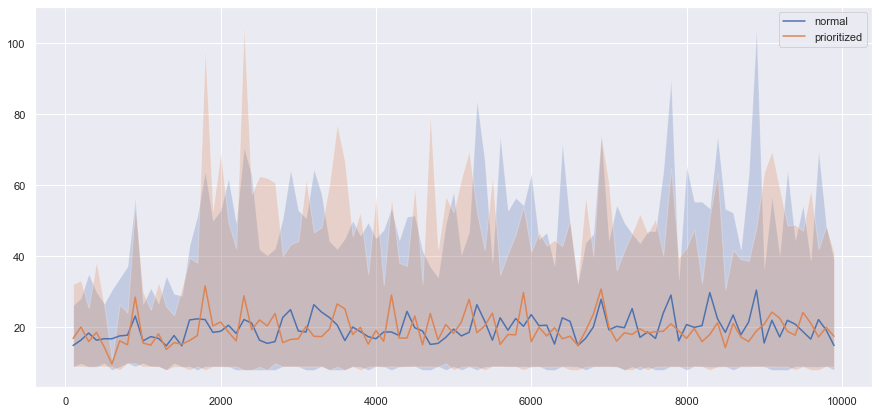

In [67]:
key = 'test_ep_returns'
plt.figure(figsize=(15,7))
for sd in results:
    plot_percentiles(results[sd]['test_ep_steps'][0],results[sd][key].T,label=sd)
_ = plt.legend()

In [13]:
p = results['prioritized']['priorities'].ravel()
ip = 1/p

In [14]:
ip

array([32.00292042, 18.639029  ,  9.56032025, ...,  6.27653628,
        6.84753722,  7.0937098 ])

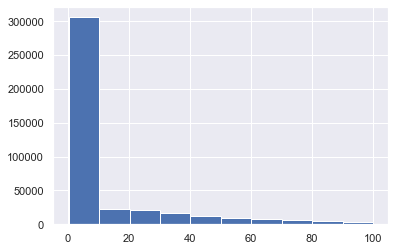

In [15]:
_ = plt.hist(ip)

(array([3.86182e+05, 1.05250e+04, 1.25630e+04, 6.60000e+01, 3.60000e+01,
        3.20000e+01, 1.90000e+01, 4.40000e+01, 7.90000e+01, 5.40000e+01]),
 array([0.01      , 0.38386544, 0.75773087, 1.13159631, 1.50546175,
        1.87932718, 2.25319262, 2.62705806, 3.00092349, 3.37478893,
        3.74865437]),
 <a list of 10 Patch objects>)

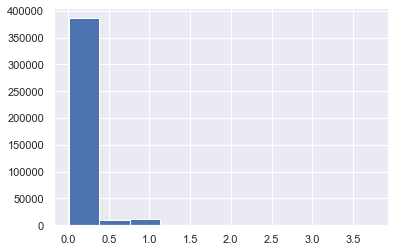

In [16]:
plt.hist(p)

In [17]:
ip.max()

100.00000223517424

In [18]:
w = ip/ip.sum()*(len(ip))

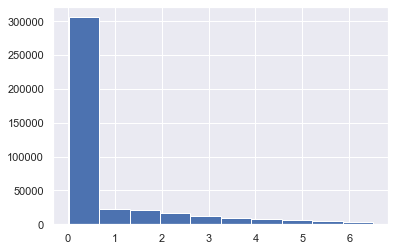

In [19]:
_ = plt.hist(w)

In [20]:
p2 = p-0.1

In [21]:
ip2 = 1./p2

In [22]:
w2 = ip2/ip2.sum()*(len(ip2))

/Users/justinmaojones/rl/env/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


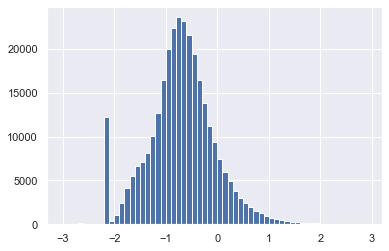

In [23]:
_ = plt.hist(np.log10(w2),bins=np.arange(-3,3,0.1))

In [24]:
sorted(w2)[-20:]

[1583.3813208968136,
 1682.3040117768833,
 1682.3040117768833,
 1682.3040117768833,
 1794.4109013581908,
 1922.5259143960259,
 2242.7801010737567,
 2242.7801010737567,
 2691.05594888467,
 2795.8342467000302,
 3119.754217354058,
 3363.294749544778,
 3363.294749544778,
 3843.336819062132,
 3843.336819062132,
 6721.3425494217945,
 6721.3425494217945,
 8957.132170868397,
 13421.746337085146,
 13421.746337085146]

In [25]:
w.sum()

409599.99999999977

In [26]:
w2.sum()

409600.0000000001

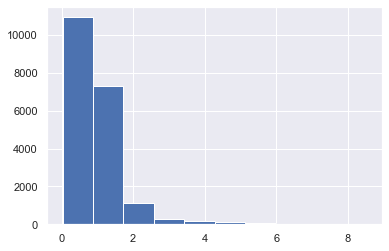

In [27]:
_ = plt.hist(results['prioritized']['sample_importance_weights'].ravel())

In [28]:
results['prioritized']['sample_importance_weights'].mean()

0.8657705565811011

In [29]:
from agentflow.buffers import PrioritizedBufferMap

In [30]:
buffer = PrioritizedBufferMap(2**2,alpha=1,eps=0.1,wclip=1e20)

In [31]:
priorities = results['prioritized']['priorities'][0]

In [32]:
priorities.shape

(10, 2048)

In [33]:
priorities = np.random.randn(10,2048)

In [34]:
for k in range(2):
    for i in range(priorities.shape[1]):
        x = priorities[:,i]
        buffer.append({'x':x},x)

In [35]:
output = buffer.sample(1000000,beta=1.)

In [36]:
buffer._sum_tree._flat_base

array([0.58586055, 0.42206007, 1.09485506, 2.90205057, 0.2466963 ,
       1.32457643, 0.12764351, 0.88701497, 2.05906249, 0.32510562,
       0.13054174, 2.04817803, 1.21318179, 0.21507919, 0.21306764,
       0.289777  , 1.26871853, 0.91278558, 1.75984077, 1.64379151,
       0.921057  , 1.10323675, 1.81716691, 0.49232585, 0.16299328,
       0.87580862, 0.18499641, 1.29475039, 0.33999127, 0.40616263,
       0.90497227, 1.26714792, 0.7366756 , 0.91342692, 1.71977146,
       0.11912974, 1.42285483, 0.78732281, 0.36611121, 0.66342905])

In [37]:
probs_sample = (buffer._idx_sample[:,None] == np.arange(len(buffer._sum_tree._flat_base))[None,:]).mean(axis=0)

In [38]:
probs = buffer._sum_tree._flat_base/buffer._sum_tree._flat_base.sum()

In [39]:
probs_sample - probs

array([-1.71766553e-04,  5.19595670e-05,  9.96455932e-05,  2.18631069e-04,
       -1.45614778e-04,  5.93506656e-05, -4.10647097e-05, -3.30292235e-05,
       -4.35870782e-05, -4.24614392e-05,  2.78055216e-05,  1.63446026e-05,
        1.05169337e-04, -8.94706067e-05, -1.03855596e-04,  4.82978231e-05,
        3.09699714e-04,  1.53469416e-04,  4.22408399e-05,  3.05749940e-04,
       -1.95217238e-04, -2.62089829e-04, -4.17701706e-04,  5.22640695e-05,
       -2.14085670e-05, -2.61198130e-04, -3.97471644e-05,  2.79756799e-05,
        5.09829801e-05,  6.24891632e-05, -2.50952134e-06, -4.08763650e-05,
        3.85264174e-05, -8.62621311e-05, -3.69300072e-05, -1.21677606e-04,
        1.08167303e-04,  2.66241386e-04, -7.01764648e-05,  1.81633626e-04])

In [40]:
(1./buffer._sum_tree._flat_base).sum()

90.45850535968414

In [41]:
buffer._inv_sum

90.45850535968448

In [42]:
output['importance_weight'].mean()

0.9978454570931562

In [43]:
buffer._sum_tree._flat_base[buffer._idx_sample]

array([0.90497227, 0.88701497, 1.75984077, ..., 1.64379151, 0.87580862,
       0.289777  ])

In [44]:
ipr = 1./buffer._sum_tree[buffer._idx_batch,buffer._idx_time]
N = buffer._sum_tree.size
ipr_sum = buffer._inv_sum
w = (ipr / ipr_sum * N) ** 1.
print(w.mean())
w = np.minimum(w,buffer._wclip)
w.mean()

0.4879718136763008


0.4879718136763008

In [45]:
a = np.random.choice(
    buffer._sum_tree._flat_base,size=10000,p=buffer._sum_tree._flat_base/buffer._sum_tree._flat_base.sum())
ia = 1./a

In [46]:
(ia/(1./buffer._sum_tree._flat_base).sum() * buffer._sum_tree.size).mean()

0.48925995516195736

In [47]:
(ia/buffer._inv_sum * buffer._sum_tree.size).mean()

0.48925995516195553

(array([8076.,  800.,  463.,  279.,   76.,  111.,   57.,   42.,    0.,
          96.]),
 array([0.15237215, 0.5083199 , 0.86426765, 1.2202154 , 1.57616314,
        1.93211089, 2.28805864, 2.64400639, 2.99995413, 3.35590188,
        3.71184963]),
 <a list of 10 Patch objects>)

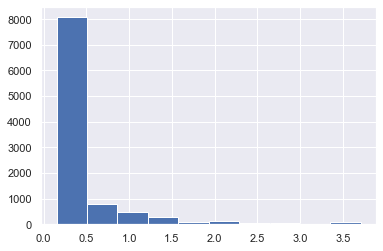

In [48]:
plt.hist((ia/buffer._inv_sum * buffer._sum_tree.size))

In [49]:
buffer._idx_sample

array([30,  7, 18, ..., 19, 25, 15], dtype=int32)

In [50]:
len(buffer._sum_tree)

10

In [51]:
idx_sample = np.arange(20480)
idx_batch = idx_sample // buffer._sum_tree.time_dim_size
idx_time = idx_sample - (idx_batch * buffer._sum_tree.time_dim_size)

In [52]:
idx_time

array([0, 1, 2, ..., 1, 2, 3])

In [53]:
pr = buffer._sum_tree[idx_batch,idx_time]
ipr = 1./pr

IndexError: index 10 is out of bounds for axis 0 with size 10

In [ ]:
N = buffer._sum_tree.size
N

In [ ]:
ipr_sum = buffer._inv_sum
ipr_sum

In [ ]:
ipr.sum()

In [ ]:
w = (ipr / ipr_sum * N)
w.mean()

In [ ]:
w = np.minimum(w,buffer._wclip)
w.mean()

In [ ]:
_ = buffer.sample(10000)

In [ ]:
buffer.update_priorities(np.random.randn(10000))